In [1]:
#from comet_ml import Experiment
import json
import wandb
import os
import yaml

In [2]:
import os

In [3]:
with open("/glock/gun/notebooks/api_key.txt", "r") as f:
    api_key = json.load(f)
    print("opened")
os.environ["WANDB_API_KEY"] = api_key["api_key"]

opened


In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("weapons", {}, "/Pobrane/trainval.json", "/Pobrane/images")
register_coco_instances("weapons_test", {}, "/Pobrane/test.json", "/Pobrane/images")
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000000})

In [5]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [6]:
dataset_dicts = DatasetCatalog.get("weapons")
dataset_metadata = MetadataCatalog.get("weapons")
dataset_dicts_test = DatasetCatalog.get("weapons_test")
dataset_metadata_test = MetadataCatalog.get("weapons_test")

In [7]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/Pobrane/images/35.png
/Pobrane/images/57.png
/Pobrane/images/18.png
/Pobrane/images/21.png
/Pobrane/images/36.png
/Pobrane/images/81.png
/Pobrane/images/77.png
/Pobrane/images/15.png
/Pobrane/images/27.png
/Pobrane/images/8.png


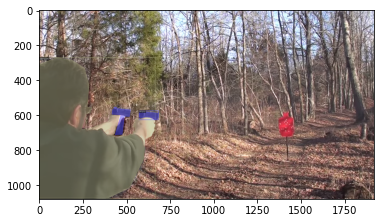

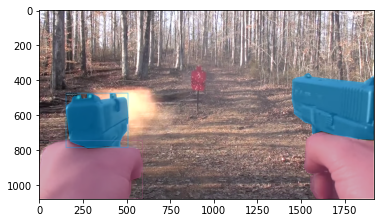

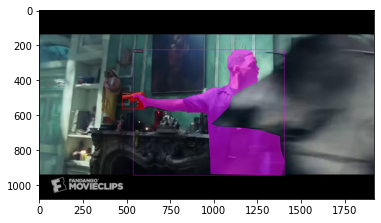

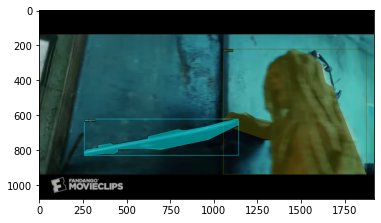

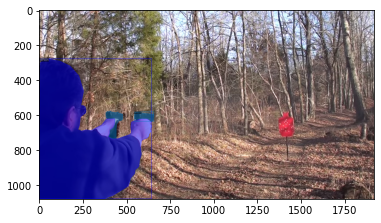

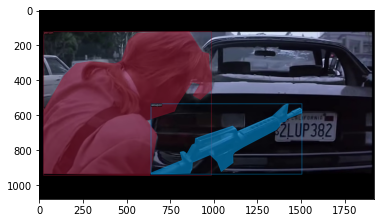

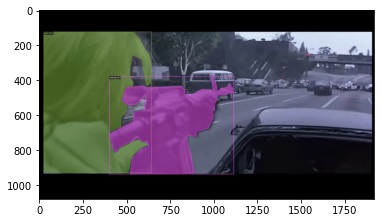

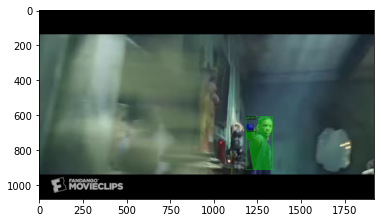

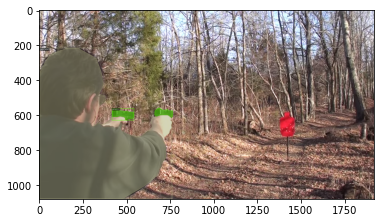

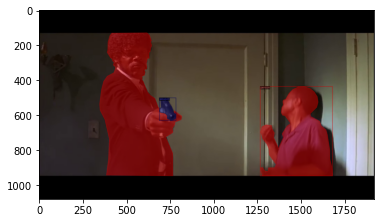

In [8]:
for d in random.sample(dataset_dicts_test, 10):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata_test, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

/Pobrane/images/More-weapons-1/People with weapons_71300_original.png
/Pobrane/images/More-weapons-1/People with weapons_75220_original.png
/Pobrane/images/More-weapons-1/table_33570_original.png
/Pobrane/images/More-weapons-1/table_54195_original.png
/Pobrane/images/More-weapons-1/table_5715_original.png
/Pobrane/images/More-weapons-1/AKM_7324_original.png
/Pobrane/images/More-weapons-1/Browning_HP_7959_original.png
/Pobrane/images/More-weapons-1/People with weapons_73778_original.png
/Pobrane/images/More-weapons-1/table_35360_original.png
/Pobrane/images/More-weapons-1/45_ACP_Smith_And_Wesson _26893_original.png
/Pobrane/images/More-weapons-1/table_63162_original.png
/Pobrane/images/More-weapons-1/VKS_Vyhlop_70749_original.png
/Pobrane/images/More-weapons-1/Browning_HP_25927_original.png


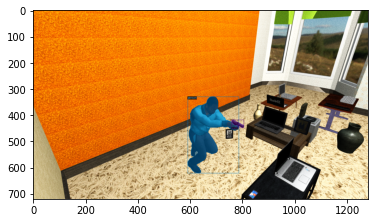

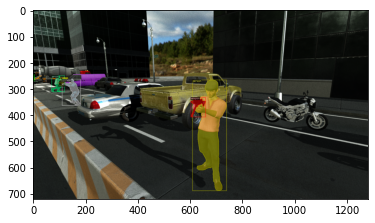

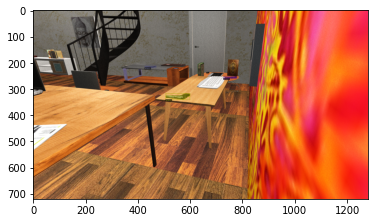

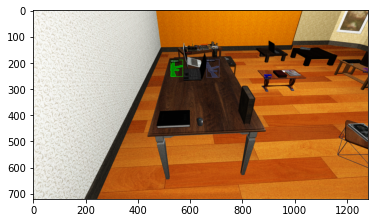

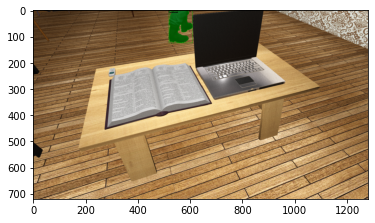

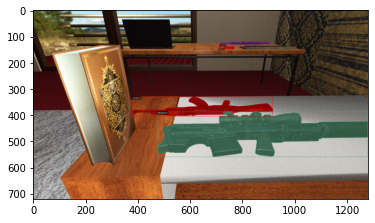

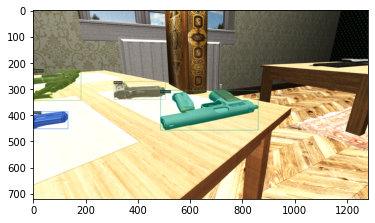

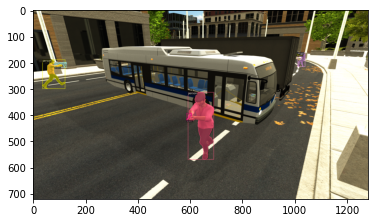

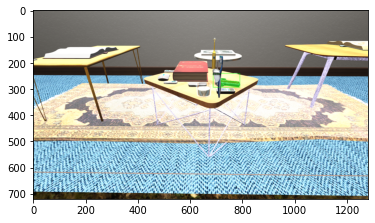

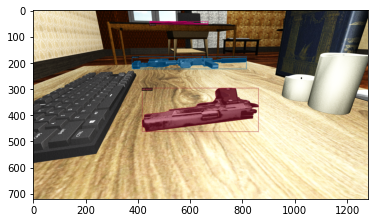

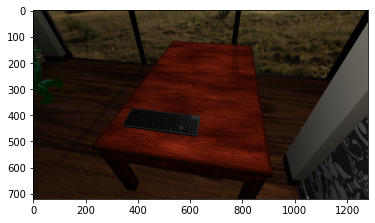

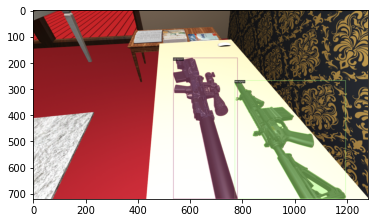

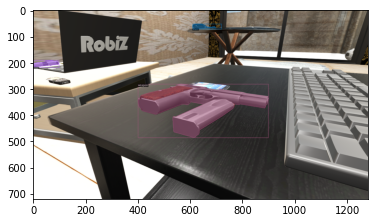

In [9]:
for d in random.sample(dataset_dicts, 13):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [10]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [11]:
from datetime import datetime
import os

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"/glock/tboard_logs/weapons"#_{datetime.now().isoformat().rsplit(':', 1)[0]}/"

cfg.DATASETS.TRAIN = ("weapons",)
cfg.DATASETS.TEST = ("weapons_test",)
cfg.DATALOADER.NUM_WORKERS = 0

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.RETINANET.NUM_CLASSES = 2
#cfg.MODEL.BACKBONE.FREEZE_AT=1
# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 4 # 32
cfg.SOLVER.BASE_LR =0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 500_000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS =  10000
cfg.SOLVER.GAMMA = 0.8
cfg.SOLVER.STEPS = (40000, 80000, 120000, 200000, 500000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 3000 
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

In [13]:
def cfg_node_to_dict(cfg):
    """
    We needs this because ``yacs`` over-encapsulates this logic:
    https://github.com/rbgirshick/yacs/blob/32d5e4ac/yacs/config.py#L188-L204
    """
    raw_cfg = yaml.safe_load(cfg.dump())
    return raw_cfg


In [14]:
config = cfg_node_to_dict(cfg)
wandb.init(sync_tensorboard=True, project="weapons")

wandb: Currently logged in as: miotk (use `wandb login --relogin` to force relogin)


In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open("/glock/gun/config.yml", "w") as f:
    f.write(cfg.dump())

In [16]:
'''
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)
'''

'\nfrom detectron2.engine.hooks import HookBase\nfrom detectron2.evaluation import inference_context\nfrom detectron2.utils.logger import log_every_n_seconds\nfrom detectron2.data import DatasetMapper, build_detection_test_loader\nimport detectron2.utils.comm as comm\nimport torch\nimport time\nimport datetime\n\nclass LossEvalHook(HookBase):\n    def __init__(self, eval_period, model, data_loader):\n        self._model = model\n        self._period = eval_period\n        self._data_loader = data_loader\n    \n    def _do_loss_eval(self):\n        # Copying inference_on_dataset from evaluator.py\n        total = len(self._data_loader)\n        num_warmup = min(5, total - 1)\n            \n        start_time = time.perf_counter()\n        total_compute_time = 0\n        losses = []\n        for idx, inputs in enumerate(self._data_loader):            \n            if idx == num_warmup:\n                start_time = time.perf_counter()\n                total_compute_time = 0\n            

In [17]:
#https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [18]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    '''                 
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
    '''
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/02 22:25:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/02 22:25:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/02 22:25:14 d2.data.datasets.coco]: Loading /Pobrane/trainval.json takes 12.32 seconds.
[12/02 22:25:14 d2.data.datasets.coco]: Loaded 69988 images in COCO format from /Pobrane/trainval.json
[12/02 22:25:17 d2.data.build]: Removed 0 images with no usable annotations. 69988 images left.
[12/02 22:25:19 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   weapon   | 226296       |   person   | 37545        |
|            |              |            |              |
|   total    | 263841       |            |              |
[12/02 22:25:19 d2.data.build]: Using training sampler TrainingSampler
[12/02 22:25:19 d2.data.common]: Serializing 69988 ele

KeyboardInterrupt: 

In [ ]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("weapons")
glock_test_metadata = MetadataCatalog.get("weapons")

In [ ]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
#cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/weapon_images_from_google"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())